This script explores the correlation between Twitter hashtag tweets and COVID-19 related statistics.


*   Tweets vs. New Florida Positive Cases
*   Tweets vs. Dade Percent Positive
*   Tweets vs. Dade Occupied Beds



# Import Libraries

In [8]:
#!pip install tweepy
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from time import sleep
from datetime import datetime

# Declare Global Variables

In [2]:
# Data Files
TWEETS_FILE = "tweets.csv"
COVID_FILE = "covid_dade_20210421-29.csv"

# Keys for access to Twitter API
CONSUMER_KEY = "vos7herQgmNcFceJ5Uc7GtQrF"
CONSUMER_SECRET = "mnNnOw4sKSW6RiWgCNKwBAei0OfsnvDS2PXF0Xgr6dfxxLmLxr"
ACCESS_KEY = "1082988361416171523-M6A31iNOtALrfe16mZVasxEy0FITdf"
ACCESS_SECRET = "V5T4xJilyvmwbSCoDwuPRqODyRS8hwY9KI9LGbcJhWhhk"

# Authentication variables
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

# Connects to twitter to download tweets
def scrape(words, date_since, date_until, numOfTweets):
    #collect tweets
    tweets = tweepy.Cursor(api.search,q=words,since=date_since,until=date_until).items(numOfTweets)
    #for tweet in tweets:
    #  print(tweet)
    users_locs = [[tweet.text, tweet.created_at] for tweet in tweets] #tweet.user.location
                 
    # Creating DataFrame using pandas
    db = pd.DataFrame(data=users_locs, columns=['text', 'created at'])
    db['created at'] = pd.to_datetime(db['created at'], errors='coerce')
    db["date"] = db["created at"].dt.date
    return db

# Data Preparation

## Download Tweets (only if not tweets.csv does not exist)

In [ ]:
# Download one day's worth of tweets per iteration
words = '#miami'

print("Starting:", datetime.now())
tweets = pd.DataFrame()

# Download the last 14 days of tweets
for i in range(1, 15):
    startDate = (datetime.now() - timedelta(days = i)).strftime("%Y-%m-%d")
    endDate = (datetime.now() - timedelta(days = i-1)).strftime("%Y-%m-%d")
    attempts = 0

    # Try to download each tweet at least 3 times
    while attempts < 3:

        print(startDate, "Attempt:", attempts, "~", datetime.now())
        currTweets = scrape(words, startDate, endDate, 5000)

        if len(currTweets) == 0:
            attempts = attempts + 1
            sleep(60)
        else:
            print(startDate)
            tweets = pd.concat([tweets, currTweets])
            print("Tweets length:", len(tweets), datetime.now())
            display(tweets)
            tweets.to_csv("tweets.csv", index = False, header = True, mode = 'w')
            break

display(tweets)

print('Complete:', datetime.now())

## Load tweets

In [3]:
# Read the saved tweets
tweets = pd.read_csv(TWEETS_FILE)
tweets["date"] = pd.to_datetime(tweets["date"])
display(tweets)

,text,created at,date
0,Relaxing on the beach in Miami with the wife.#...,2021-04-30 14:13:23,2021-04-30
1,RT @betashop: I arrived in Miami 1 week ago to...,2021-04-30 14:13:17,2021-04-30
2,RT @ValentinaP444: 🆘🆘URGENT! #FL #MIAMI DEADli...,2021-04-30 14:13:17,2021-04-30
3,"RT @ConflitsFrance: 🇺🇸 DRAME | #USA, mardi der...",2021-04-30 14:12:51,2021-04-30
4,RT @ValentinaP444: 🆘🆘#A2222472 #FL #MIAMI 3yo ...,2021-04-30 14:12:50,2021-04-30
...,...,...,...
24287,RT @Rise_Realty: new #Miami #LittleRiver #Busi...,2021-04-22 16:46:11,2021-04-22
24288,RT @Guajiritasoy: #ConsularServicesInCuba #cu...,2021-04-22 16:46:08,2021-04-22
24289,It's 83F in #Miami with cloudy skies &amp; win...,2021-04-22 16:46:07,2021-04-22
24290,RT @timand2037: The #CIA proposed bombing refu...,2021-04-22 16:45:30,2021-04-22


In [4]:
# Aggregate the tweets to count tweets per day
# Count tweets per date: Aggregate tweets by date
tweetsSummary = tweets.groupby(["date"]).agg({'text' : ['count']})
tweetsSummary.columns = tweetsSummary.columns.get_level_values(0)
tweetsSummary.reset_index(inplace= True)
tweetsSummary.rename(columns = {"text": "tweets"}, inplace = True)
display(tweetsSummary)

tweetsSummary.to_csv("Tweet_Summary.csv", index = False, header = True) 

,date,tweets
0,2021-04-22,1139
1,2021-04-23,2449
2,2021-04-24,2173
3,2021-04-25,4406
4,2021-04-26,3154
5,2021-04-27,3216
6,2021-04-28,2952
7,2021-04-29,2934
8,2021-04-30,1869


## Load Pre-Downloaded COVID Data

In [5]:
# Load COVID Data
covid = pd.read_csv(COVID_FILE)
covid["date"] = pd.to_datetime(covid["date"])
display(covid)

,date,Dade Percent Positive,Negative Cases,Positive Cases,FL New COVID-19 Cases,Dade Available Beds,Dade Occupied Beds
0,2021-04-22,6.73,13219,954,954,1836,6715
1,2021-04-23,6.29,22111,1484,1484,1826,6706
2,2021-04-24,6.10,14286,928,928,1805,6726
3,2021-04-25,6.94,10709,799,799,2031,6472
4,2021-04-26,6.05,16293,1049,1049,2137,6550
5,2021-04-27,5.25,16491,913,913,1929,6624
6,2021-04-28,5.53,18295,1070,1070,1847,6693
7,2021-04-29,5.37,16361,929,929,1770,6765


## Merge Tweet Summary + COVID Data

In [6]:
# Merge Tweets and COVID data by date
tweetsCovid = pd.merge(tweetsSummary, covid, left_on = "date", right_on = "date")
display(tweetsCovid)

,date,tweets,Dade Percent Positive,Negative Cases,Positive Cases,FL New COVID-19 Cases,Dade Available Beds,Dade Occupied Beds
0,2021-04-22,1139,6.73,13219,954,954,1836,6715
1,2021-04-23,2449,6.29,22111,1484,1484,1826,6706
2,2021-04-24,2173,6.10,14286,928,928,1805,6726
3,2021-04-25,4406,6.94,10709,799,799,2031,6472
4,2021-04-26,3154,6.05,16293,1049,1049,2137,6550
5,2021-04-27,3216,5.25,16491,913,913,1929,6624
6,2021-04-28,2952,5.53,18295,1070,1070,1847,6693
7,2021-04-29,2934,5.37,16361,929,929,1770,6765


# Data Visualization

## Pair Plot

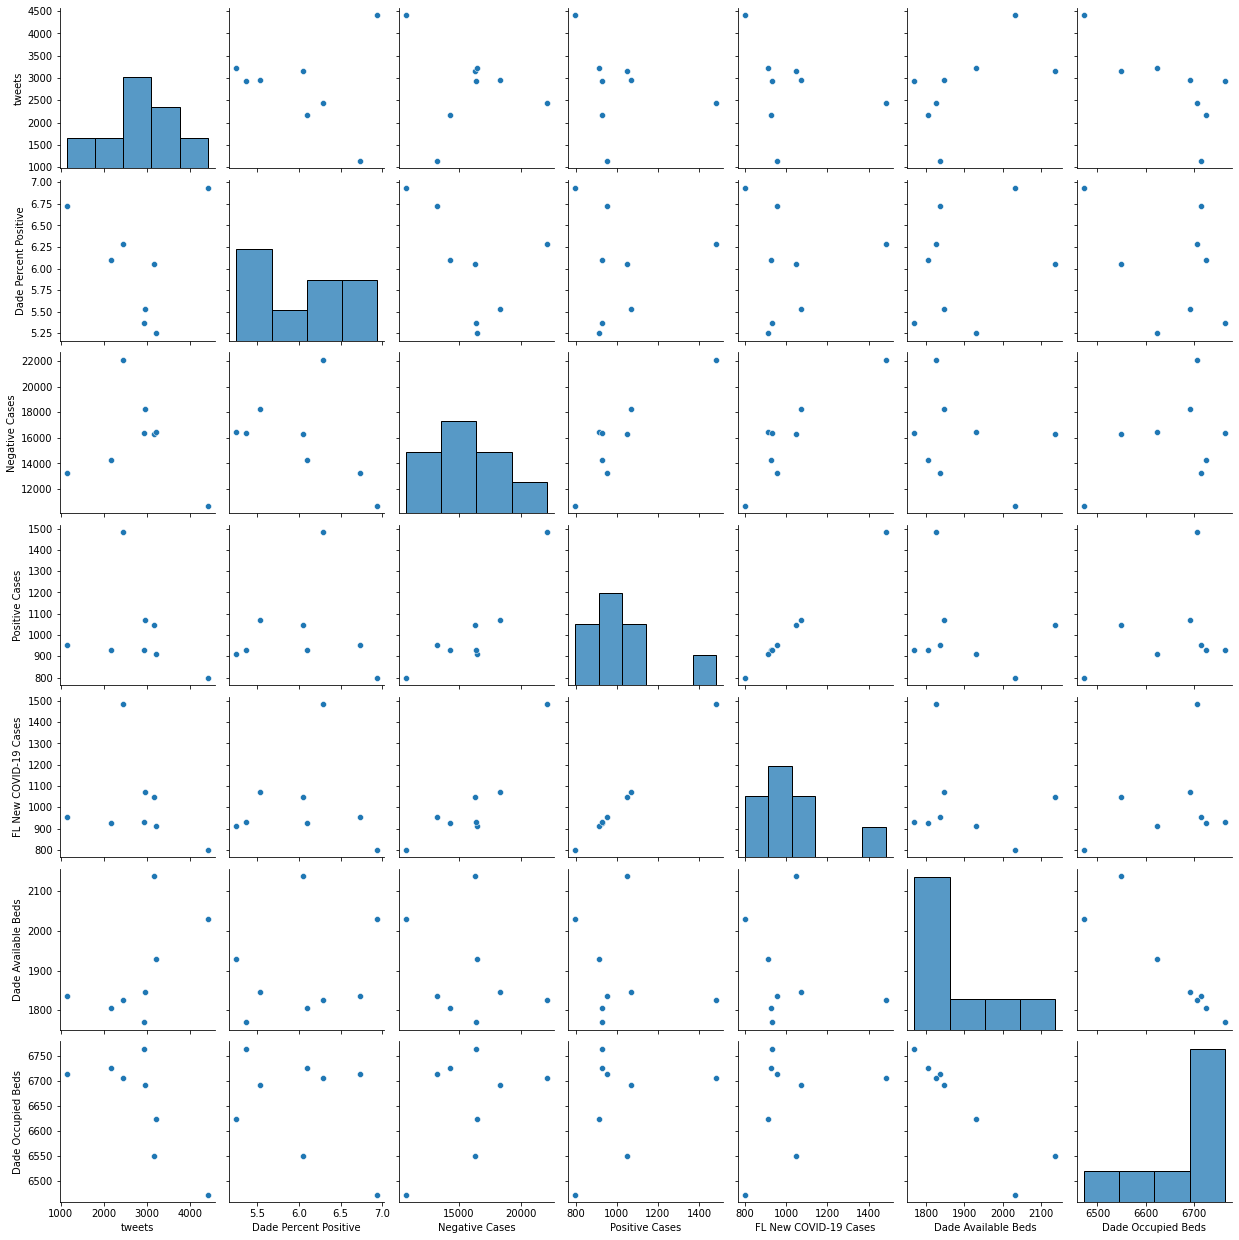

In [9]:
# Visualize the data
display(sns.pairplot(tweetsCovid))

## Individual Plots

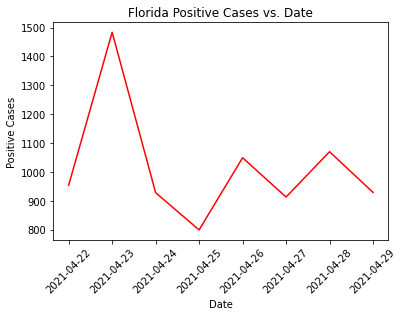

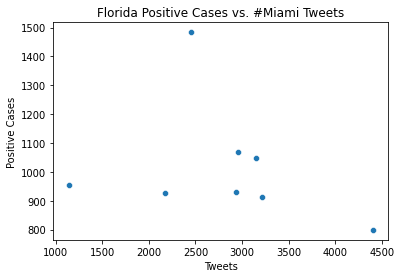

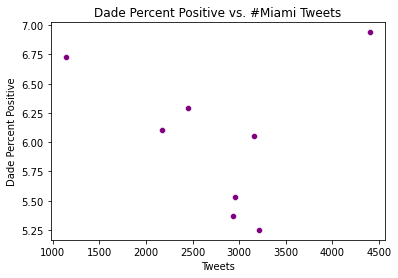

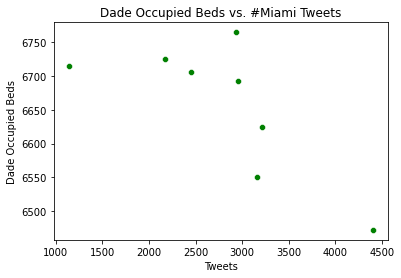

In [13]:
# Data Visualization

# Florida Positive Cases vs. Date
fig = sns.lineplot(data=tweetsCovid, x="date", y="Positive Cases", color = "red")
plt.xlabel("Date")
plt.ylabel("Positive Cases")
plt.title("Florida Positive Cases vs. Date")
plt.xticks(rotation=45)
plt.show(fig)

# Florida Positive Cases vs. #Miami Tweets
fig = sns.scatterplot(data=tweetsCovid, x="tweets", y="Positive Cases")
plt.xlabel("Tweets")
plt.ylabel("Positive Cases")
plt.title("Florida Positive Cases vs. #Miami Tweets") 
plt.show(fig)

# Dade Percent Positive vs. #Miami Tweets
fig = sns.scatterplot(data=tweetsCovid, x="tweets", y="Dade Percent Positive", color = "purple")
plt.xlabel("Tweets")
plt.ylabel("Dade Percent Positive")
plt.title("Dade Percent Positive vs. #Miami Tweets") 
plt.show(fig)

# Dade Occupied Beds vs. #Miami Tweets
fig = sns.scatterplot(data=tweetsCovid, x="tweets", y="Dade Occupied Beds", color = "green")
plt.xlabel("Tweets")
plt.ylabel("Dade Occupied Beds")
plt.title("Dade Occupied Beds vs. #Miami Tweets") 
plt.show(fig)

# Correlation

Correlation Rules:
*   Strong Negative: -1 to -.75
*   Weak Negative: -.74 to -.5
*   No Correlation: -.49 to .49
*   Weak Positive: .5 to .74
*   Strong Positive: .75 to 1

In [11]:
# Correlation
display(tweetsCovid.corr())

,tweets,Dade Percent Positive,Negative Cases,Positive Cases,FL New COVID-19 Cases,Dade Available Beds,Dade Occupied Beds
tweets,1.000000,-0.078050,-0.188564,-0.285589,-0.285589,0.566532,-0.736122
Dade Percent Positive,-0.078050,1.000000,-0.476254,-0.015519,-0.015519,0.260247,-0.404909
Negative Cases,-0.188564,-0.476254,1.000000,0.885320,0.885320,-0.293590,0.447660
Positive Cases,-0.285589,-0.015519,0.885320,1.000000,1.000000,-0.203974,0.315721
FL New COVID-19 Cases,-0.285589,-0.015519,0.885320,1.000000,1.000000,-0.203974,0.315721
Dade Available Beds,0.566532,0.260247,-0.293590,-0.203974,-0.203974,1.000000,-0.904736
Dade Occupied Beds,-0.736122,-0.404909,0.447660,0.315721,0.315721,-0.904736,1.000000
